<a href="https://colab.research.google.com/github/archana070723/Womanium_project/blob/main/Quantum_Walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane qiskit qiskit-aer  --quiet


In [2]:

from qiskit import QuantumCircuit

def gate_counts(qc: QuantumCircuit, verbose=True):
    """
    Returns a dict of {gate_name: count} and total gate count for a circuit qc.
    """
    counts = qc.count_ops()   # counts per operation name
    total = sum(counts.values())
    if verbose:
        print("Gate counts:")
        for g, c in counts.items():
            print(f"  {g}: {c}")
        print("Total gates:", total)
    return dict(counts), total


In [3]:
#----------GAUSSIAN DISTRIBUTION  (WITHOUT NOISE)---------------------------------


from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.stats import norm, expon, entropy
import numpy as np
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt

# Quantum peg logic
def quantum_peg(qc, control, mid):

    left = mid - 1
    right = mid + 1
    print("Quantum peg on qubits:",left,mid,right)
    # print()
    if left != control and mid != control:
        qc.cswap(control, left, mid)
    qc.cx(mid, control)
    if mid != control and right != control:
        qc.cswap(control, mid, right)

# General QGB circuit builder
def generate_qgb_qiskit(n_qubits, n_levels, shots=8192):
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits )
    qc = QuantumCircuit(qr, cr)
    mid = n_qubits // 2
    qc.x(qr[mid])  # Ball starts in center
    qc.h(qr[0])  # Ball starts in center



    for j in range(n_levels):
      mid2=mid
      # print("For level=",j)
      control = 0
      if j == 0:
             quantum_peg(qc, control, mid)
      else:
          qc.reset(qr[control])
          qc.h(qr[control])
          mid2=mid2-j
          for i in range(j+1):
            rightmost=mid2+1
            if( mid2-1 !=0 and mid2 + 1 !=n_qubits ):
              # print("mid2=",mid2)
              quantum_peg(qc, control, mid2 )
              if (i!=j):
                qc.cx(qr[rightmost], qr[control])
              mid2=mid2+2
              # print("Updated mid2=",mid2)
              # quantum_peg(qc, control, mid + (j))
    qc.barrier()
    for i in range(1, n_qubits ):
        qc.measure(qr[i], cr[i])
    print(qc.draw())
    sim = AerSimulator()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    print (counts)
    plt.figure(figsize=(10, 5))
    # Plot raw measurement histogram before postprocessing
    plot_histogram(counts, title="Raw QGB Measurement Counts")
    plt.show()
    return qc,counts

# Post-processing
def process_results(counts, dist_type="gaussian"):
    keys = list(counts.keys())
    values = [int(k, 2) for k in keys]
    total = sum(counts.values())
    normalized_sim = {int(k, 2): v / total for k, v in counts.items()}
    x = np.arange(min(values), max(values)+1)

    if dist_type == "gaussian":
        mu, sigma = 16, np.sqrt(5)
        ideal = norm.pdf(x, mu, sigma)
    elif dist_type == "exponential":
        ideal = expon.pdf(x, scale=4)
    else:
        ideal = np.ones_like(x) / len(x)

    ideal = ideal #/ np.sum(ideal)
    sim = np.array([normalized_sim.get(i, 0) for i in x])
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    tvd = 0.5 * np.sum(np.abs(sim - ideal))

    plt.figure(figsize=(10, 5))
    plt.bar(x, sim, label="QGB Simulated", alpha=0.6)
    plt.plot(x, ideal, label=f"Ideal {dist_type.title()} Distribution", color="r", linestyle="--")
    plt.xlabel("Output value")
    plt.ylabel("Probability")
    plt.title(f"QGB Simulation vs. Ideal {dist_type.title()} Distribution")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return kl, tvd, normalized_sim
# Post-processing with 4-bit rescaling and block summing
def process_and_plot_blocked(counts, dist_type="gaussian"):
    shots = sum(counts.values())
    strings = []
    for bitstring, count in counts.items():
        strings.extend([bitstring] * count)

    remapped = []
    for s in strings:
        index = s[::-1].find('1')
        remapped.append(index if index != -1 else 4)  # Map to 0–4

    blocks = [sum(remapped[i:i+8]) for i in range(0, len(remapped), 8) if len(remapped[i:i+8]) == 8]
    x = sorted(set(blocks))
    hist = {i: blocks.count(i) for i in x}
    total = sum(hist.values())
    normalized_sim = {k: v / total for k, v in hist.items()}

    x_vals = np.arange(min(x), max(x) + 1)
    sim = np.array([normalized_sim.get(i, 0) for i in x_vals])

    if dist_type == "gaussian":
        mu, sigma = 16, np.sqrt(5)
        ideal = norm.pdf(x_vals, mu, sigma)
    elif dist_type == "exponential":
        ideal = expon.pdf(x_vals, scale=4)
    else:
        ideal = np.ones_like(x_vals) / len(x_vals)

    ideal = ideal #/ np.sum(ideal)
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    tvd = 0.5 * np.sum(np.abs(sim - ideal))

    plt.figure(figsize=(10, 5))
    plt.bar(x_vals, sim, label="QGB Simulated", alpha=0.6)
    plt.plot(x_vals, ideal, label=f"Ideal {dist_type.title()} Distribution", color="r", linestyle="--")
    plt.xlabel("Sum of 8 Block Values")
    plt.ylabel("Probability")
    plt.title(f"Postprocessed QGB Output vs. Ideal {dist_type.title()} Distribution")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return kl, tvd, normalized_sim

# Run for 2 layers
layers = 5
n_qubits = 2 * layers + 2
qc,counts = generate_qgb_qiskit(n_qubits, layers)
print(counts)
# kl_gauss, tvd_gauss, _ = process_and_plot_blocked(counts, dist_type="gaussian")

# counts_exp = generate_qgb_qiskit(n_qubits, layers)
# kl_exp, tvd_exp, _ = process_and_plot_blocked(counts_exp, dist_type="exponential")


Quantum peg on qubits: 5 6 7
Quantum peg on qubits: 4 5 6
Quantum peg on qubits: 6 7 8
Quantum peg on qubits: 3 4 5
Quantum peg on qubits: 5 6 7
Quantum peg on qubits: 7 8 9
Quantum peg on qubits: 2 3 4
Quantum peg on qubits: 4 5 6
Quantum peg on qubits: 6 7 8
Quantum peg on qubits: 8 9 10
Quantum peg on qubits: 1 2 3
Quantum peg on qubits: 3 4 5
Quantum peg on qubits: 5 6 7
Quantum peg on qubits: 7 8 9
Quantum peg on qubits: 9 10 11
       ┌───┐   ┌───┐        ┌───┐   ┌───┐   ┌───┐   ┌───┐        ┌───┐   ┌───┐»
 q0_0: ┤ H ├─■─┤ X ├─■──|0>─┤ H ├─■─┤ X ├─■─┤ X ├─■─┤ X ├─■──|0>─┤ H ├─■─┤ X ├»
       └───┘ │ └─┬─┘ │      └───┘ │ └─┬─┘ │ └─┬─┘ │ └─┬─┘ │      └───┘ │ └─┬─┘»
 q0_1: ──────┼───┼───┼────────────┼───┼───┼───┼───┼───┼───┼────────────┼───┼──»
             │   │   │            │   │   │   │   │   │   │            │   │  »
 q0_2: ──────┼───┼───┼────────────┼───┼───┼───┼───┼───┼───┼────────────┼───┼──»
             │   │   │            │   │   │   │   │   │   │            │   │  »
 q

<Figure size 1000x500 with 0 Axes>

{'000000000010': 284, '100000000000': 245, '000010000000': 2474, '000000001000': 1325, '001000000000': 1291, '000000100000': 2573}


['000000000010', '000000001000', '000000100000', '000010000000', '001000000000', '100000000000']


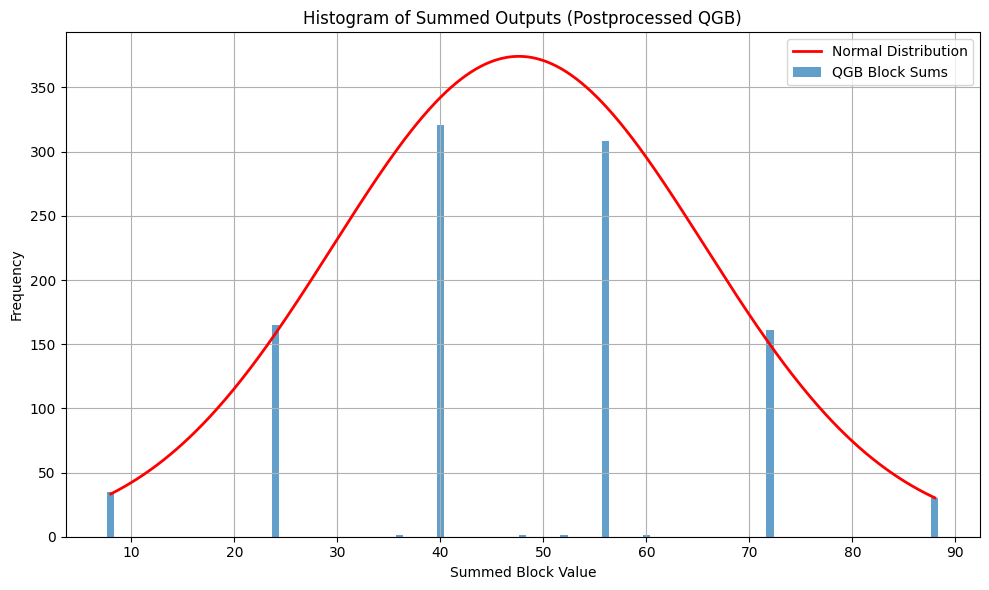

TVD: 0.55624511696554
Gate counts:
  cswap: 30
  cx: 25
  measure: 11
  h: 5
  reset: 4
  x: 1
  barrier: 1
Total gates: 77


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Generic function to map 1-hot bitstring to integer index
def one_hot_to_int(bitstring):
    # Qiskit gives bitstrings in little-endian, so reverse it
    bitstring = bitstring[::-1]
    if bitstring.count('1') != 1:
        return None  # Not a valid 1-hot bitstring
    return bitstring.index('1')

# Step 1: Expand counts into a flat sample list
def expand_onehot_counts(counts):
    samples = []
    for bitstring, freq in counts.items():
        val = one_hot_to_int(bitstring)
        if val is not None:
            samples.extend([val] * freq)
    return samples

# Step 2: Postprocessing block sum
def block_sum_postprocessing(samples, block_size=8):
    num_blocks = len(samples) // block_size
    block_sums = [
        sum(samples[i*block_size:(i+1)*block_size])
        for i in range(num_blocks)
    ]
    return block_sums

# Step 3: Plotting
def plot_histogram_and_gaussian(block_sums):
    hist = Counter(block_sums)
    sorted_keys = sorted(hist.keys())
    frequencies = [hist[k] for k in sorted_keys]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_keys, frequencies, width=0.7, alpha=0.7, label='QGB Block Sums')
    plt.xlabel("Summed Block Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of Summed Outputs (Postprocessed QGB)")
    plt.grid(True)

    # Overlay Gaussian
    mean = np.mean(block_sums)
    std = np.std(block_sums)
    mean, scale = np.mean(block_sums), np.std(block_sums)
    x = np.linspace(min(sorted_keys), max(sorted_keys), 500)
    gaussian = 16.5*len(block_sums) * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)
    plt.plot(x, gaussian, color='red', linewidth=2, label='Normal Distribution')

    plt.legend()
    plt.tight_layout()
    plt.show()
    sim = frequencies
    sim /= np.sum(sim)
    ideal=gaussian
    # ideal = expon.pdf(x, scale=scale)
    ideal /= np.sum(ideal)
    # print("IDEAL=",ideal)
    # print("SIM=",sim)

    # Ideal Gaussian evaluated only at these 8 points
    mean = np.mean(block_sums)
    std = np.std(block_sums)
    ideal_vals = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((np.array(sorted_keys) - mean) / std)**2)
    ideal = ideal_vals / ideal_vals.sum()  # normalize to sum to 1

    # TVD only on the 8 points
    tvd = 0.5 * np.sum(np.abs(sim - ideal))
    # print("TVD (8 bins):", tvd)
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    # tvd = 0.5 * np.sum(np.abs(sim - ideal))
    return kl, tvd

# Example usage:
# counts = {'0010000000': 130, '0001000000': 246, '1000000000': 135, '0000100000': 513, ...}
samples = expand_onehot_counts(counts)
print(sorted(counts.keys()))
block_sums = block_sum_postprocessing(samples, block_size=8)
kl,tvd=plot_histogram_and_gaussian(block_sums)
# print("KL Divergence:", kl)
print("TVD:", tvd)



counts_dict, total_gates = gate_counts(qc)



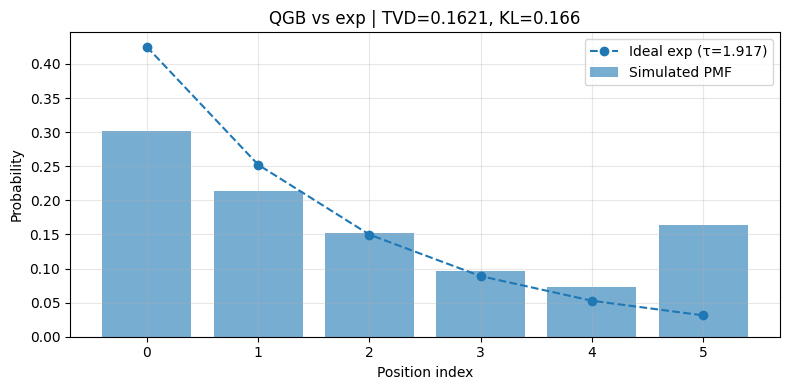

TVD=
0.16208367363295662
Gate counts:
  ccx: 55
  cswap: 25
  x: 12
  measure: 6
  ry: 5
  cx: 5
  barrier: 5
Total gates: 113


In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import RYGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def bit_to_index(b):
    s = b[::-1]                       # little-endian fix
    return s.find('1') if s.count('1') == 1 else None

def move_one_step_right(qc, pos_reg, cont_q, scratch_q):
    """Move the one-hot token exactly one site right if cont==1.
       Uses a scratch that is cleaned each time (uncomputed correctly)."""
    n = len(pos_reg)
    for k in range(n-2, -1, -1):             # scan right->left -> triggers once
        qc.ccx(cont_q, pos_reg[k], scratch_q)            # t = cont & pos[k]
        qc.cswap(scratch_q, pos_reg[k], pos_reg[k+1])    # swap right if t==1
        qc.ccx(cont_q, pos_reg[k+1], scratch_q)          # uncompute using NEW location

def truncated_geometric_pmf(p, kmax):
    """P(K=k)=(1-p)p^k for k<kmax, and p^kmax at kmax; normalized."""
    ks = np.arange(0, kmax+1)
    pmf = (1-p) * (p ** ks)
    pmf[-1] = p ** kmax
    pmf /= pmf.sum()
    return ks, pmf

# ---------- main generator ----------
def generate_qgb_exponential(n_qubits, n_levels, r=0.7, start_index=0, shots=8192, plot=True):
    pos   = QuantumRegister(n_qubits, "q")
    cont  = QuantumRegister(1, "cont")
    coin  = QuantumRegister(n_levels, "coin")     # per-level biased coins
    workL = QuantumRegister(n_levels, "wL")       # per-level latch ancillas (garbage ok)
    workM = QuantumRegister(1, "wM")              # move scratch (must be cleaned each use)
    creg  = ClassicalRegister(n_qubits, "c")
    qc    = QuantumCircuit(pos, cont, coin, workL, workM, creg)

    # capacity: max steps to the right from start_index
    right_capacity = (n_qubits - 1) - start_index
    if n_levels > right_capacity:
        print(f"[warn] n_levels={n_levels} exceeds right capacity {right_capacity}; mass accumulates at boundary.")

    # init one-hot at start; cont=1
    qc.x(pos[start_index])
    qc.x(cont[0])

    # biased coin P(continue=1)=r
    alpha = np.arcsin(np.sqrt(r))
    ry_r = RYGate(2*alpha)

    for j in range(n_levels):
        # coin_j
        qc.append(ry_r, [coin[j]])

        # ---- LATCH: cont := cont AND coin_j ----
        # Copy original cont to wL[j], then if coin==0 and original cont==1, flip cont -> 0.
        qc.cx(cont[0], workL[j])             # wL[j] = cont_old
        qc.x(coin[j])                        # coin' = ~coin
        qc.ccx(coin[j], workL[j], cont[0])   # if coin'==1 and cont_old==1 -> flip cont
        qc.x(coin[j])                        # restore coin
        # (wL[j] keeps garbage 'cont_old'; fine, we won't reuse it)

        # move exactly one step if cont==1
        move_one_step_right(qc, pos, cont[0], workM[0])
        qc.barrier()

    # measure positions
    for i in range(n_qubits):
        qc.measure(pos[i], creg[i])

    sim = AerSimulator()
    res = sim.run(transpile(qc, sim), shots=shots).result()
    counts = res.get_counts()

    if plot:
        plot_histogram(counts, title=f"Exponential walk (r={r:.2f}, start={start_index})")
        plt.show()
    return qc, counts, start_index, right_capacity

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

def bit_to_index(bitstr: str):
    s = bitstr[::-1]                      # Qiskit counts are little-endian
    return s.find('1') if s.count('1') == 1 else None

def counts_to_pos_pmf(counts: dict):
    pos = {}
    tot = 0
    for b, v in counts.items():
        ix = bit_to_index(b)
        if ix is None:
            continue
        pos[ix] = pos.get(ix, 0) + v
        tot += v
    xs = np.array(sorted(pos))
    sim = np.array([pos[x] for x in xs], float)
    sim /= sim.sum()
    return xs, sim

def compare_to_exp(counts, scale=None, rate=None, plot=True, title="Sim vs exp"):
    """
    Compare simulated PMF (from counts) to ideal exponential exp(-x/scale) sampled on the same bins.
    - If 'scale' (tau) is None and 'rate' (lambda) is None, fit tau = mean(y).
    - If 'rate' is given, scale = 1/rate.
    We shift support so y = xs - xs.min() (exp starts at 0).
    """
    xs, sim = counts_to_pos_pmf(counts)
    y = xs - xs.min()

    if rate is not None:
        tau = 1.0 / float(rate)
    elif scale is not None:
        tau = float(scale)
    else:
        # MLE for exponential with support at 0 is mean of y
        tau = float(np.sum(y * sim))  # same as y.mean() when sim is a PMF
        tau = max(tau, 1e-12)

    # Ideal exp pmf sampled on the same bins and normalized
    ideal_vals = np.exp(-y / tau)
    ideal = ideal_vals / ideal_vals.sum()

    tvd = 0.5 * np.abs(sim - ideal).sum()
    kl  = entropy(sim + 1e-12, ideal + 1e-12)  # optional

    if plot:
        plt.figure(figsize=(8,4))
        plt.bar(xs, sim, alpha=0.6, label="Simulated PMF")
        plt.plot(xs, ideal, "o--", label=f"Ideal exp (τ={tau:.3f})")
        plt.xlabel("Position index")
        plt.ylabel("Probability")
        plt.title(f"{title} | TVD={tvd:.4f}, KL={kl:.3f}")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"xs": xs, "sim": sim, "ideal": ideal, "tau": tau, "tvd": tvd, "kl": kl}


# -------------- demo --------------
if __name__ == "__main__":
    layers = 5
    n_qubits = layers + 1  # 7
    start = 0              # left edge
    r=0.7

    qc, counts, start_idx, cap = generate_qgb_exponential(
        n_qubits, layers, r=0.7, start_index=start, shots=8192, plot=True
    )

    # Given your 'counts' from the circuit:
    metrics = compare_to_exp(counts, scale=None, plot=True, title="QGB vs exp")
    print("TVD=")
    print(metrics["tvd"])

    counts_dict, total_gates = gate_counts(qc)




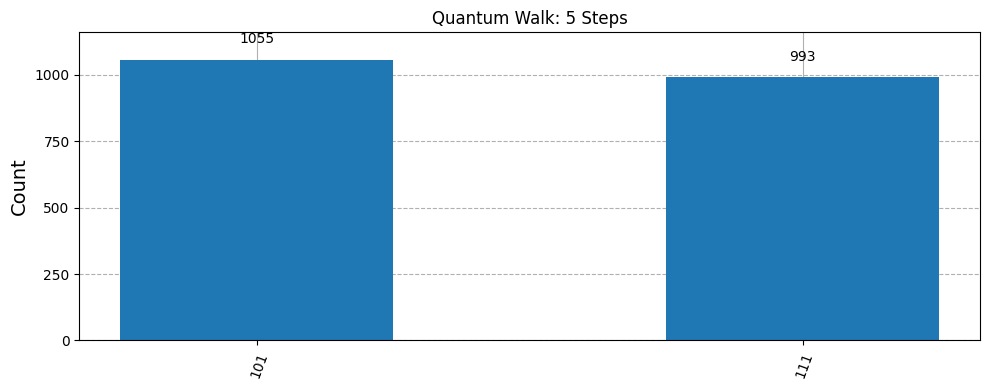

Gate counts:
  ccx: 20
  x: 11
  cx: 10
  h: 5
  measure: 3
Total gates: 49


In [6]:
#-------------------Hadamard Walk (Without Noise)---------------------------

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def controlled_increment(qc, coin, pos):
    """Apply controlled increment (coin == |0⟩)"""
    qc.x(coin)  # Flip to control on |0>
    for i in range(len(pos) - 1):
        qc.ccx(coin, pos[i], pos[i + 1])
    qc.cx(coin, pos[0])
    qc.x(coin)

def controlled_decrement(qc, coin, pos):
    """Apply controlled decrement (coin == |1⟩)"""
    qc.cx(coin, pos[0])
    for i in reversed(range(1, len(pos))):
        qc.ccx(coin, pos[i - 1], pos[i])

def quantum_walk_circuit(num_steps=3, num_pos_qubits=3):
    qr_coin = QuantumRegister(1, name='coin')
    qr_pos = QuantumRegister(num_pos_qubits, name='pos')
    cr = ClassicalRegister(num_pos_qubits, name='readout')
    qc = QuantumCircuit(qr_coin, qr_pos, cr)

    # Initialize position to the center
    center = 2 ** (num_pos_qubits - 1)
    for i, bit in enumerate(format(center, f'0{num_pos_qubits}b')[::-1]):
        if bit == '1':
            qc.x(qr_pos[i])

    for _ in range(num_steps):
        qc.h(qr_coin[0])  # Hadamard coin flip
        controlled_increment(qc, qr_coin[0], qr_pos)
        controlled_decrement(qc, qr_coin[0], qr_pos)

    # Measure position
    qc.measure(qr_pos, cr)
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=2048).result()
    counts = result.get_counts()
    return qc,counts

# --- Parameters ---
num_steps = 5
num_pos_qubits = 3

# Build and simulate
qc, counts = quantum_walk_circuit(num_steps, num_pos_qubits)




# Plot
fig = plt.figure(figsize=(10, 4))
plot_histogram(counts, ax=fig.gca(), title=f"Quantum Walk: {num_steps} Steps")
plt.grid(True)
plt.tight_layout()
plt.show()

counts_dict, total_gates = gate_counts(qc)


{'0100110110': 1, '0110110100': 1, '1011100100': 1, '0001010010': 5, '0101000100': 1, '1011100010': 1, '1000010010': 1, '0101110100': 3, '0100000110': 2, '1011001010': 2, '1100110100': 1, '1110010100': 1, '1011010100': 1, '1111001000': 4, '1000111010': 1, '1101101000': 1, '0010100100': 4, '1011110000': 3, '1010110100': 3, '1010011010': 1, '0111001010': 1, '0011001110': 2, '0110110010': 3, '0011011010': 1, '0110111000': 1, '0001111010': 5, '0111000110': 1, '0101101010': 4, '0001100100': 6, '1101000000': 5, '1100010000': 1, '0010111100': 17, '0100001100': 7, '0010110000': 135, '1100100000': 59, '0001001100': 18, '0111000000': 19, '1001100000': 35, '1100101010': 1, '1001010110': 1, '0011101100': 8, '0000000100': 83, '1000100010': 1, '1010101100': 6, '1010001000': 17, '0100111100': 3, '1110011110': 1, '1101001100': 1, '1000110000': 35, '0010101000': 112, '1110001100': 3, '1001011100': 3, '1011000000': 31, '1010000010': 2, '0100101000': 9, '0110001110': 2, '1100001000': 46, '0001011000': 73

<Figure size 1000x500 with 0 Axes>

['0000000010', '0000000100', '0000001000', '0000001110', '0000010000', '0000010110', '0000011010', '0000011100', '0000100000', '0000100110', '0000101010', '0000101100', '0000110010', '0000110100', '0000111000', '0000111110', '0001000000', '0001000110', '0001001010', '0001001100', '0001010010', '0001010100', '0001011000', '0001011110', '0001100010', '0001100100', '0001101000', '0001101110', '0001110000', '0001111010', '0001111100', '0010000000', '0010000110', '0010001010', '0010001100', '0010010010', '0010010100', '0010011000', '0010011110', '0010100010', '0010100100', '0010101000', '0010101110', '0010110000', '0010110110', '0010111010', '0010111100', '0011000010', '0011000100', '0011001000', '0011001110', '0011010000', '0011011010', '0011011100', '0011100000', '0011100110', '0011101010', '0011101100', '0011110010', '0011111000', '0011111110', '0100000000', '0100000110', '0100001010', '0100001100', '0100011000', '0100101000', '0100110000', '0100110110', '0100111010', '0100111100', '0101

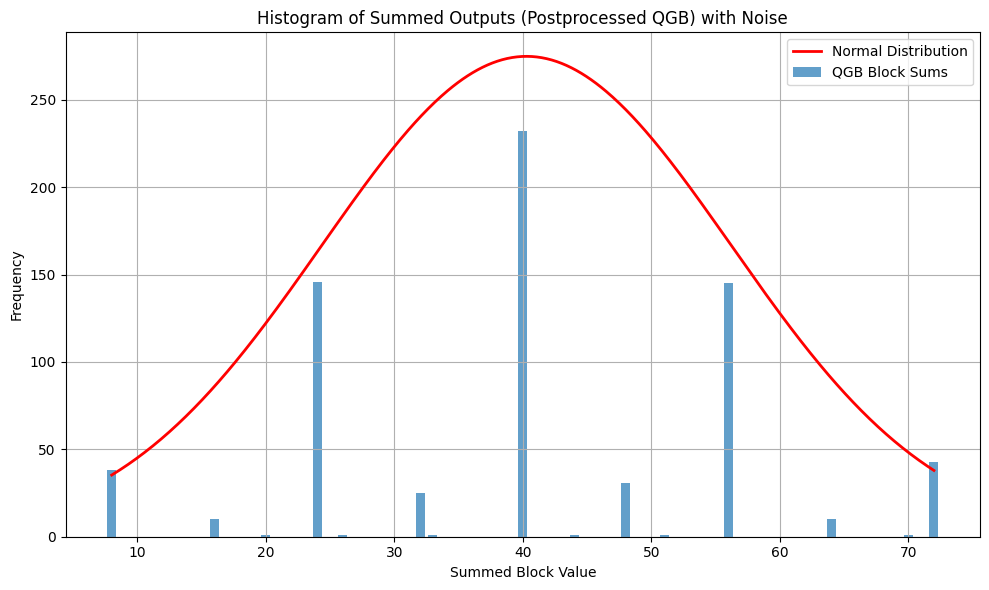

TVD (8 bins): 0.600628689384499
TVD: 0.600628689384499


In [7]:
#--------------- Gaussian Distribution of Galton Board With Noise------------------

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.stats import norm, expon, entropy
import numpy as np
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt
from qiskit_aer.noise import NoiseModel, phase_damping_error, pauli_error
#---------------------ADDING NOISE MODEL_-------------------------------
# --- tune these ---
p1 = 0.01   # 1-qubit dephasing prob per 1q gate
p2 = 0.02   # 2-qubit dephasing prob per 2q gate
p_idle = 0.001  # idle dephasing (optional)
# ------------------

noise_model = NoiseModel()
# Optional: idle dephasing (apply to identity to mimic between-gate decoherence)
if p_idle > 0:
    noise_model.add_all_qubit_quantum_error(phase_damping_error(p_idle), ['id'])

# True dephasing (phase damping) on 1q gates
dephase_1q = phase_damping_error(p1)
noise_model.add_all_qubit_quantum_error(
    dephase_1q, ['h','x','sx','rx','ry','rz']
)

# True dephasing on 2q gates (apply to each qubit)
dephase_2q = phase_damping_error(p2).tensor(phase_damping_error(p2))
noise_model.add_all_qubit_quantum_error(dephase_2q, ['cx'])
#--------------------- NOISE MODEL -------------------------------

# Quantum peg logic
def quantum_peg(qc, control, mid):

    left = mid - 1
    right = mid + 1
    # print("Quantum peg on qubits:",left,mid,right)
    # print()
    if left != control and mid != control:
        qc.cswap(control, left, mid)
    qc.cx(mid, control)
    if mid != control and right != control:
        qc.cswap(control, mid, right)

# General QGB circuit builder
def generate_qgb_qiskit_with_noise(n_qubits, n_levels, shots=8192):
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits )
    qc = QuantumCircuit(qr, cr)
    mid = n_qubits // 2
    qc.x(qr[mid])  # Ball starts in center
    qc.h(qr[0])  # Ball starts in center

    # for i in range(n_levels):
    #     print("For level=",i)
    #     control = 0
    #     if i == 0:
    #         # quantum_peg(qc, control, mid)
    #     else:
    #         qc.reset(qr[control])
    #         qc.h(qr[control])

    for j in range(n_levels):
      mid2=mid
      # print("For level=",j)
      control = 0
      if j == 0:
             quantum_peg(qc, control, mid)
      else:
          qc.reset(qr[control])
          qc.h(qr[control])
          mid2=mid2-j
          for i in range(j+1):
            rightmost=mid2+1
            if( mid2-1 !=0 and mid2 + 1 !=n_qubits ):
              # print("mid2=",mid2)
              quantum_peg(qc, control, mid2 )
              if (i!=j):
                qc.cx(qr[rightmost], qr[control])
              mid2=mid2+2
              # print("Updated mid2=",mid2)
              # quantum_peg(qc, control, mid + (j))
    qc.barrier()
    for i in range(1, n_qubits ):
        qc.measure(qr[i], cr[i])




  # Run with noise
    sim = AerSimulator(noise_model=noise_model)
    qc_t = transpile(qc, sim, optimization_level=1)
    result = sim.run(qc_t, shots=8192).result()
    counts = result.get_counts()


    print (counts)
    plt.figure(figsize=(10, 5))
    # Plot raw measurement histogram before postprocessing
    plot_histogram(counts, title="Raw QGB Measurement Counts")
    plt.show()
    return counts

# Post-processing
def process_results(counts, dist_type="gaussian"):
    keys = list(counts.keys())
    values = [int(k, 2) for k in keys]
    total = sum(counts.values())
    normalized_sim = {int(k, 2): v / total for k, v in counts.items()}
    x = np.arange(min(values), max(values)+1)

    if dist_type == "gaussian":
        mu, sigma = 16, np.sqrt(5)
        ideal = norm.pdf(x, mu, sigma)
    elif dist_type == "exponential":
        ideal = expon.pdf(x, scale=4)
    else:
        ideal = np.ones_like(x) / len(x)

    ideal = ideal #/ np.sum(ideal)
    sim = np.array([normalized_sim.get(i, 0) for i in x])
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    tvd = 0.5 * np.sum(np.abs(sim - ideal))

    # plt.figure(figsize=(10, 5))
    # plt.bar(x, sim, label="QGB Simulated", alpha=0.6)
    # plt.plot(x, ideal, label=f"Ideal {dist_type.title()} Distribution", color="r", linestyle="--")
    # plt.xlabel("Output value")
    # plt.ylabel("Probability")
    # plt.title(f"QGB Simulation vs. Ideal {dist_type.title()} Distribution")
    # plt.legend()
    # plt.grid()
    # plt.tight_layout()
    # plt.show()

    return kl, tvd, normalized_sim
# Post-processing with 4-bit rescaling and block summing
def process_and_plot_blocked(counts, dist_type="gaussian"):
    shots = sum(counts.values())
    strings = []
    for bitstring, count in counts.items():
        strings.extend([bitstring] * count)

    remapped = []
    for s in strings:
        index = s[::-1].find('1')
        remapped.append(index if index != -1 else 4)  # Map to 0–4

    blocks = [sum(remapped[i:i+8]) for i in range(0, len(remapped), 8) if len(remapped[i:i+8]) == 8]
    x = sorted(set(blocks))
    hist = {i: blocks.count(i) for i in x}
    total = sum(hist.values())
    normalized_sim = {k: v / total for k, v in hist.items()}

    x_vals = np.arange(min(x), max(x) + 1)
    sim = np.array([normalized_sim.get(i, 0) for i in x_vals])

    if dist_type == "gaussian":
        mu, sigma = 16, np.sqrt(5)
        ideal = norm.pdf(x_vals, mu, sigma)
    elif dist_type == "exponential":
        ideal = expon.pdf(x_vals, scale=4)
    else:
        ideal = np.ones_like(x_vals) / len(x_vals)

    ideal = ideal #/ np.sum(ideal)
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    tvd = 0.5 * np.sum(np.abs(sim - ideal))



    return kl, tvd, normalized_sim

# Run for 2 layers
layers = 4
n_qubits = 2 * layers + 2
counts = generate_qgb_qiskit_with_noise(n_qubits, layers)
# print(counts)
# kl_gauss, tvd_gauss, _ = process_and_plot_blocked(counts, dist_type="gaussian")

# counts_exp = generate_qgb_qiskit(n_qubits, layers)
# kl_exp, tvd_exp, _ = process_and_plot_blocked(counts_exp, dist_type="exponential")
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Generic function to map 1-hot bitstring to integer index
def one_hot_to_int(bitstring):
    # Qiskit gives bitstrings in little-endian, so reverse it
    bitstring = bitstring[::-1]
    if bitstring.count('1') != 1:
        return None  # Not a valid 1-hot bitstring
    return bitstring.index('1')

# Step 1: Expand counts into a flat sample list
def expand_onehot_counts(counts):
    samples = []
    for bitstring, freq in counts.items():
        val = one_hot_to_int(bitstring)
        if val is not None:
            samples.extend([val] * freq)
    return samples

# Step 2: Postprocessing block sum
def block_sum_postprocessing(samples, block_size=8):
    num_blocks = len(samples) // block_size
    block_sums = [
        sum(samples[i*block_size:(i+1)*block_size])
        for i in range(num_blocks)
    ]
    return block_sums

# Step 3: Plotting
def plot_histogram_and_gaussian(block_sums):
    hist = Counter(block_sums)
    sorted_keys = sorted(hist.keys())
    frequencies = [hist[k] for k in sorted_keys]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_keys, frequencies, width=0.7, alpha=0.7, label='QGB Block Sums')
    plt.xlabel("Summed Block Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of Summed Outputs (Postprocessed QGB) with Noise")
    plt.grid(True)

    # Overlay Gaussian
    mean = np.mean(block_sums)
    std = np.std(block_sums)
    mean, scale = np.mean(block_sums), np.std(block_sums)
    x = np.linspace(min(sorted_keys), max(sorted_keys), 500)
    gaussian = 16*len(block_sums) * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)
    plt.plot(x, gaussian, color='red', linewidth=2, label='Normal Distribution')

    plt.legend()
    plt.tight_layout()
    plt.show()
    sim = frequencies
    sim /= np.sum(sim)
    ideal=gaussian
    # ideal = expon.pdf(x, scale=scale)
    ideal /= np.sum(ideal)
    # print("IDEAL=",ideal)
    # print("SIM=",sim)

    # Ideal Gaussian evaluated only at these 8 points
    mean = np.mean(block_sums)
    std = np.std(block_sums)
    ideal_vals = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((np.array(sorted_keys) - mean) / std)**2)
    ideal = ideal_vals / ideal_vals.sum()  # normalize to sum to 1

    # TVD only on the 8 points
    tvd = 0.5 * np.sum(np.abs(sim - ideal))
    print("TVD (8 bins):", tvd)
    kl = entropy(sim + 1e-12, ideal + 1e-12)
    # tvd = 0.5 * np.sum(np.abs(sim - ideal))
    return kl, tvd

# Example usage:
# counts = {'0010000000': 130, '0001000000': 246, '1000000000': 135, '0000100000': 513, ...}
samples = expand_onehot_counts(counts)
print(sorted(counts.keys()))
block_sums = block_sum_postprocessing(samples, block_size=8)
kl,tvd=plot_histogram_and_gaussian(block_sums)
# print("KL Divergence:", kl)
print("TVD:", tvd)


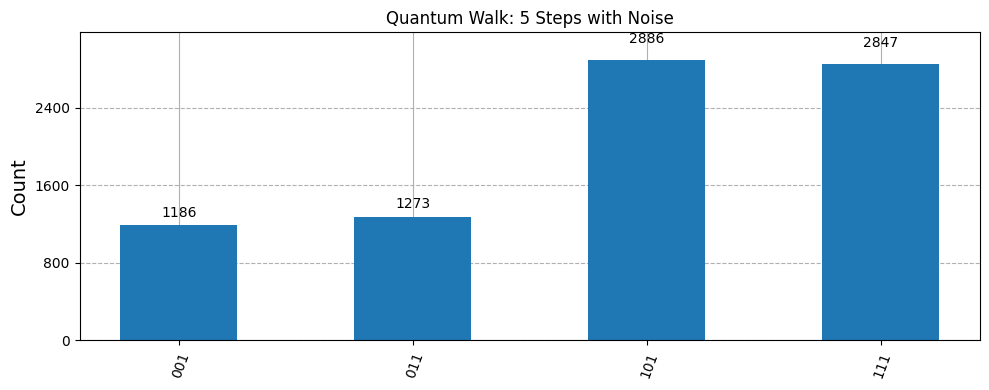

Position-level TVD: 0.5


In [8]:
#-------------------Hadamard Walk With Noise---------------------------

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def controlled_increment(qc, coin, pos):
    """Apply controlled increment (coin == |0⟩)"""
    qc.x(coin)  # Flip to control on |0>
    for i in range(len(pos) - 1):
        qc.ccx(coin, pos[i], pos[i + 1])
    qc.cx(coin, pos[0])
    qc.x(coin)

def controlled_decrement(qc, coin, pos):
    """Apply controlled decrement (coin == |1⟩)"""
    qc.cx(coin, pos[0])
    for i in reversed(range(1, len(pos))):
        qc.ccx(coin, pos[i - 1], pos[i])

def quantum_walk_circuit_with_noise(num_steps=3, num_pos_qubits=3):
    qr_coin = QuantumRegister(1, name='coin')
    qr_pos = QuantumRegister(num_pos_qubits, name='pos')
    cr = ClassicalRegister(num_pos_qubits, name='readout')
    qc = QuantumCircuit(qr_coin, qr_pos, cr)

    # Initialize position to the center
    center = 2 ** (num_pos_qubits - 1)
    for i, bit in enumerate(format(center, f'0{num_pos_qubits}b')[::-1]):
        if bit == '1':
            qc.x(qr_pos[i])

    for _ in range(num_steps):
        qc.h(qr_coin[0])  # Hadamard coin flip
        controlled_increment(qc, qr_coin[0], qr_pos)
        controlled_decrement(qc, qr_coin[0], qr_pos)

    # Measure position
    qc.measure(qr_pos, cr)
    return qc

# --- Parameters ---
num_steps = 5
num_pos_qubits = 3

# Build and simulate

qc = quantum_walk_circuit_with_noise(num_steps, num_pos_qubits)
 # Run with noise
sim = AerSimulator(noise_model=noise_model)
qc_t = transpile(qc, sim, optimization_level=3)
result = sim.run(qc_t, shots=8192).result()
counts = result.get_counts()


# Plot
fig = plt.figure(figsize=(10, 4))
plot_histogram(counts, ax=fig.gca(), title=f"Quantum Walk: {num_steps} Steps with Noise")
plt.grid(True)
plt.tight_layout()
plt.show()

def bit_to_pos(bitstr):
    s = bitstr[::-1]                 # Qiskit counts are little-endian
    return s.find('1') if s.count('1')==1 else None

def counts_to_pos_pmf(counts):
    pos_counts = {}
    total = 0
    for b,v in counts.items():
        pos = bit_to_pos(b)
        if pos is None:  # skip non-one-hot outcomes
            continue
        pos_counts[pos] = pos_counts.get(pos, 0) + v
        total += v
    return {k: v/total for k,v in pos_counts.items()} if total else {}

def tvd_over_positions(measured_counts, ideal_counts):
    p = counts_to_pos_pmf(measured_counts)
    q = counts_to_pos_pmf(ideal_counts)
    keys = set(p)|set(q)
    return 0.5 * sum(abs(p.get(k,0)-q.get(k,0)) for k in keys)

# usage with noiseless reference:
# --- Parameters ---
num_steps = 5
num_pos_qubits = 3

# Build and simulate
qc, ideal_bit_counts = quantum_walk_circuit(num_steps, num_pos_qubits)



tvd_pos = tvd_over_positions(counts, ideal_bit_counts)
print("Position-level TVD:", tvd_pos)



In [ ]:
#-------------------Exponential walk With Noise---------------------------


from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import RYGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from qiskit_aer.noise import NoiseModel, phase_damping_error, pauli_error
#---------------------ADDING NOISE MODEL_-------------------------------
# --- tune these ---
p1 = 0.01   # 1-qubit dephasing prob per 1q gate
p2 = 0.02   # 2-qubit dephasing prob per 2q gate
p_idle = 0.001  # idle dephasing (optional)
# ------------------

noise_model = NoiseModel()
# Optional: idle dephasing (apply to identity to mimic between-gate decoherence)
if p_idle > 0:
    noise_model.add_all_qubit_quantum_error(phase_damping_error(p_idle), ['id'])

# True dephasing (phase damping) on 1q gates
dephase_1q = phase_damping_error(p1)
noise_model.add_all_qubit_quantum_error(
    dephase_1q, ['h','x','sx','rx','ry','rz']
)

# True dephasing on 2q gates (apply to each qubit)
dephase_2q = phase_damping_error(p2).tensor(phase_damping_error(p2))
noise_model.add_all_qubit_quantum_error(dephase_2q, ['cx'])
#--------------------- NOISE MODEL -------------------------------

# ---------- helpers ----------
def bit_to_index(b):
    s = b[::-1]                       # little-endian fix
    return s.find('1') if s.count('1') == 1 else None

def move_one_step_right(qc, pos_reg, cont_q, scratch_q):
    """Move the one-hot token exactly one site right if cont==1.
       Uses a scratch that is cleaned each time (uncomputed correctly)."""
    n = len(pos_reg)
    for k in range(n-2, -1, -1):             # scan right->left -> triggers once
        qc.ccx(cont_q, pos_reg[k], scratch_q)            # t = cont & pos[k]
        qc.cswap(scratch_q, pos_reg[k], pos_reg[k+1])    # swap right if t==1
        qc.ccx(cont_q, pos_reg[k+1], scratch_q)          # uncompute using NEW location

def truncated_geometric_pmf(p, kmax):
    """P(K=k)=(1-p)p^k for k<kmax, and p^kmax at kmax; normalized."""
    ks = np.arange(0, kmax+1)
    pmf = (1-p) * (p ** ks)
    pmf[-1] = p ** kmax
    pmf /= pmf.sum()
    return ks, pmf

# ---------- main generator ----------
def generate_qgb_exponential_with_noise(n_qubits, n_levels, r=0.7, start_index=0, shots=8192, plot=True):
    pos   = QuantumRegister(n_qubits, "q")
    cont  = QuantumRegister(1, "cont")
    coin  = QuantumRegister(n_levels, "coin")     # per-level biased coins
    workL = QuantumRegister(n_levels, "wL")       # per-level latch ancillas (garbage ok)
    workM = QuantumRegister(1, "wM")              # move scratch (must be cleaned each use)
    creg  = ClassicalRegister(n_qubits, "c")
    qc    = QuantumCircuit(pos, cont, coin, workL, workM, creg)

    # capacity: max steps to the right from start_index
    right_capacity = (n_qubits - 1) - start_index
    if n_levels > right_capacity:
        print(f"[warn] n_levels={n_levels} exceeds right capacity {right_capacity}; mass accumulates at boundary.")

    # init one-hot at start; cont=1
    qc.x(pos[start_index])
    qc.x(cont[0])

    # biased coin P(continue=1)=r
    alpha = np.arcsin(np.sqrt(r))
    ry_r = RYGate(2*alpha)

    for j in range(n_levels):
        # coin_j
        qc.append(ry_r, [coin[j]])

        # ---- LATCH: cont := cont AND coin_j ----
        # Copy original cont to wL[j], then if coin==0 and original cont==1, flip cont -> 0.
        qc.cx(cont[0], workL[j])             # wL[j] = cont_old
        qc.x(coin[j])                        # coin' = ~coin
        qc.ccx(coin[j], workL[j], cont[0])   # if coin'==1 and cont_old==1 -> flip cont
        qc.x(coin[j])                        # restore coin
        # (wL[j] keeps garbage 'cont_old'; fine, we won't reuse it)

        # move exactly one step if cont==1
        move_one_step_right(qc, pos, cont[0], workM[0])
        qc.barrier()

    # measure positions
    for i in range(n_qubits):
        qc.measure(pos[i], creg[i])
     # Run with noise
    sim = AerSimulator(noise_model=noise_model)
    qc_t = transpile(qc, sim, optimization_level=1)
    result = sim.run(qc_t, shots=8192).result()
    counts = result.get_counts()

    # sim = AerSimulator()
    # res = sim.run(transpile(qc, sim), shots=shots).result()
    # counts = res.get_counts()

    if plot:
        plot_histogram(counts, title=f"Exponential walk with noise,(r={r:.2f}, start={start_index})")
        plt.show()
    return qc, counts, start_index, right_capacity

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

def bit_to_index(bitstr: str):
    s = bitstr[::-1]                      # Qiskit counts are little-endian
    return s.find('1') if s.count('1') == 1 else None

def counts_to_pos_pmf(counts: dict):
    pos = {}
    tot = 0
    for b, v in counts.items():
        ix = bit_to_index(b)
        if ix is None:
            continue
        pos[ix] = pos.get(ix, 0) + v
        tot += v
    xs = np.array(sorted(pos))
    sim = np.array([pos[x] for x in xs], float)
    sim /= sim.sum()
    return xs, sim

def compare_to_exp(counts, scale=None, rate=None, plot=True, title="Sim vs exp"):
    """
    Compare simulated PMF (from counts) to ideal exponential exp(-x/scale) sampled on the same bins.
    - If 'scale' (tau) is None and 'rate' (lambda) is None, fit tau = mean(y).
    - If 'rate' is given, scale = 1/rate.
    We shift support so y = xs - xs.min() (exp starts at 0).
    """
    xs, sim = counts_to_pos_pmf(counts)
    y = xs - xs.min()

    if rate is not None:
        tau = 1.0 / float(rate)
    elif scale is not None:
        tau = float(scale)
    else:
        # MLE for exponential with support at 0 is mean of y
        tau = float(np.sum(y * sim))  # same as y.mean() when sim is a PMF
        tau = max(tau, 1e-12)

    # Ideal exp pmf sampled on the same bins and normalized
    ideal_vals = np.exp(-y / tau)
    ideal = ideal_vals / ideal_vals.sum()

    tvd = 0.5 * np.abs(sim - ideal).sum()
    kl  = entropy(sim + 1e-12, ideal + 1e-12)  # optional

    if plot:
        plt.figure(figsize=(8,4))
        plt.bar(xs, sim, alpha=0.6, label="Simulated PMF")
        plt.plot(xs, ideal, "o--", label=f"Ideal exp (τ={tau:.3f})")
        plt.xlabel("Position index")
        plt.ylabel("Probability")
        plt.title(f"Exponential walk with Noise | TVD={tvd:.4f}, KL={kl:.3f}")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"xs": xs, "sim": sim, "ideal": ideal, "tau": tau, "tvd": tvd, "kl": kl}


# -------------- demo --------------
if __name__ == "__main__":
    layers = 4
    n_qubits = layers + 1  # 7
    start = 0              # left edge
    r=0.7

    qc, counts, start_idx, cap = generate_qgb_exponential_with_noise(
        n_qubits, layers, r=0.7, start_index=start, shots=8192, plot=True
    )

    # Given your 'counts' from the circuit:
    metrics = compare_to_exp(counts, scale=None, plot=True, title="QGB vs exp")
    print("TVD=")
    print(metrics["tvd"])

    counts_dict, total_gates = gate_counts(qc)


